In [1]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline

/home/hung/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def tfgaussmf(tensor_x, tensor_mean, tensor_sigma):
    """
    Calculate Gaussian fuzzy membership function
    tensor_x: input variable
    tensor_mean: parameter 'mean' of functions
    tensor_sigma: parameter 'sigma' of functions
    tensor_x, tensor_mean, tensor_sigma must have the same shape
    """
    num = -tf.square(tf.subtract(tensor_x, tensor_mean))
    den = 2*tf.square(tensor_sigma)
    return tf.exp(tf.divide(num, den))

In [3]:
def tfcartesian_prod(tensor1, tensor2):
    """
    Calculate Cartesian product of two tensor 1&2, shaped (?, n)
    Return tensor shaped (?, n, n, 2)
    (n, n) means two vectors with shape (n) with have (nxn) elements in Cartesian product
    """
    expand1 = tf.expand_dims(tf.tile(tf.expand_dims(tensor1, 2), [1,1,tf.shape(tensor2)[1]]),3)
    expand2 = tf.expand_dims(tf.tile(tf.expand_dims(tensor2, 1), [1,tf.shape(tensor1)[1],1]),3)
    
    return tf.concat([expand1, expand2], axis=3)

In [4]:
n_inputs = 4
n_mfs = 3

In [5]:
class ANFIS(object):
    
    def __init__(self, n_inputs, n_mfs, lossf='huber',learning_rate=1e-2):
        """
        Initialization method
        :param n_inputs: number of input variables, (dimmension of input)
        :param n_mfs: number of membership functions per variables
        :param learning_rate: learning rate
        """
        
        self.n = n_inputs  # input dimmension
        self.m = n_mfs     # membership functions per dimmension
                           # number of possible rules = n * m
        self.learning_rate = learning_rate
        
        # node for input
        self.inputs = tf.placeholder(tf.float32, shape=(None, n_inputs), name='input')
        # node for desired output
        self.targets = tf.placeholder(tf.float32, shape=None, name='target')
        
        # transform input
        int_t = tf.reshape(self.inputs, (-1, n_inputs, 1))
        int_t = tf.reshape(tf.tile(int_t, (1,1,n_mfs)), (-1, n_inputs, n_mfs))
        
        # initialize means
        mu = tf.get_variable(
            name='mu'+str(int(time.time())), 
            shape=[n_inputs,n_mfs],
            initializer=tf.random_normal_initializer(0.1, 1)
        )
        
        # initilize sigmas
        sigma = tf.get_variable(
            name='sigma'+str(int(time.time())), 
            shape=[n_inputs, n_mfs],
            initializer=tf.random_normal_initializer(0.1, 1)
        )
        
        # layer 1: Fuzzification layer
        self.layer1 = tfgaussmf(tensor_x=int_t, tensor_mean=mu, tensor_sigma=sigma)
        
        # layer 2: Rule operation layer
        l1s = [self.layer1[:,i,:] for i in range(n_inputs)]
        layer2 = l1s[0]
        for i in range(1, n_inputs):
            layer2 = tfcartesian_prod(layer2, l1s[i])
            layer2 = tf.reduce_prod(layer2, axis=-1)
            layer2 = tf.reshape(layer2, (-1, n_mfs**(i+1)))
            
        # layer 3 - normalization (~w_r)
        layer3 = tf.divide(layer2,tf.reduce_sum(layer2, axis=-1, keepdims=True))
        
        # layer 4 - consequent layer
        # initialise f
        center = tf.get_variable(
                    name='center'+str(int(time.time())), 
                    shape=[n_mfs**n_inputs],
                    initializer=tf.random_normal_initializer(0.1, 1)
                )
        self.params = [mu, sigma, center]
        
        layer4 = tf.multiply(layer3, center)

        # layer 5 - predited value
        self.out = tf.reduce_sum(layer4, axis=-1)
        
        # Loss - objective function
        if lossf == 'huber':
            self.loss = tf.losses.huber_loss(self.targets, self.out)
        elif lossf == 'rmse':
            self.loss = tf.sqrt(tf.losses.mean_squared_error(self.targets, self.out))
        else:
            NotImplementedError()            
        
        # Optimizer
        self.optimize = tf.train.AdamOptimizer(
            learning_rate=learning_rate
        ).minimize(self.loss)
        
        # Variable initializer
        self.init_variables = tf.global_variables_initializer()
        
    def fit(self, sess, x, targets):
        """
        Train model with input x and true value y
        sess: TensorFlow session
        Return loss and predicted values
        """
        yp, l, _ = sess.run(
            [self.out, self.loss, self.optimize], 
            feed_dict={self.inputs: x, self.targets: targets}
        )
        return l, yp
    
    def infer(self, sess, x, targets=None):
        """
        Inference process (forward pass)
        """
        if targets is None:
            # if there is no target, return predicted value
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            # else targets are defined, return predicted value and loss value
            return sess.run(
                [self.out, self.loss], 
                feed_dict={self.inputs: x, self.targets: targets}
            )
    
    def plotmfs(self, sess):
        """
        Plot membership function
        """
        xx = np.linspace(start=-10, stop=10, num=2001)
        xx = np.stack([xx for i in range(self.n)]).T
        
        layer1 = sess.run(self.layer1, {self.inputs: xx})
        
        params = sess.run(self.params)
        mu = params[0]
        sigma = params[1]
        
        for i in range(self.n):
            plt.figure(figsize=(10,7))
            for j in range(self.m):
                fun = layer1[:, i, j]
                plt.scatter(x=xx[:,0], y=fun, s=1, 
                            label="MF%d\nm: %.3f, s: %.3f"%(j+1, mu[i,j], sigma[i,j]))
                plt.title('Membership functions of %d-th variable' % (i+1))
                plt.grid(True)
                plt.legend()
                plt.xlabel('x')
                plt.ylabel('Membership function')

In [6]:
# Mackey-Glass series computation
def mackey(n_iters):
    x = np.zeros((n_iters,))
    x[0:30] = 0.23 * np.ones((30,))
    t_s = 30
    for i in range(30, n_iters - 1):
        a = x[i]
        b = x[i - t_s]
        y = ((0.2 * b) / (1 + b ** 10)) + 0.9 * a
        x[i + 1] = y
    return x


# Generate dataset
D = n_inputs  # number of regressors
T = 1  # delay
N = 2000  # Number of points to generate
mg_series = mackey(N)[499:]  # Use last 1500 points
data = np.zeros((N - 500 - T - (D - 1) * T, D))
lbls = np.zeros((N - 500 - T - (D - 1) * T,))

for t in range((D - 1) * T, N - 500 - T):
    data[t - (D - 1) * T, :] = [mg_series[t - 3*T],mg_series[t - 2*T],mg_series[t - T], mg_series[t]]
    ## [mg_series[t - 3 * T], mg_series[t - 2 * T], mg_series[t - T], mg_series[t]]
    lbls[t - (D - 1) * T] = mg_series[t + T]
    
trnData = data[:lbls.size - round(lbls.size * 0.3), :]
trnLbls = lbls[:lbls.size - round(lbls.size * 0.3)]
chkData = data[lbls.size - round(lbls.size * 0.3):, :]
chkLbls = lbls[lbls.size - round(lbls.size * 0.3):]

In [7]:
fis = ANFIS(n_inputs=n_inputs, n_mfs=3, lossf='huber')

Train cost after epoch 0: 0.521144
Train cost after epoch 10: 0.251584
Train cost after epoch 20: 0.046608
Train cost after epoch 30: 0.004621
Train cost after epoch 40: 0.006168
Train cost after epoch 50: 0.002674
Train cost after epoch 60: 0.002520
Train cost after epoch 70: 0.002167
Train cost after epoch 80: 0.002036
Train cost after epoch 90: 0.001971
Train cost after epoch 100: 0.001898
Train cost after epoch 110: 0.001847
Train cost after epoch 120: 0.001796
Train cost after epoch 130: 0.001747
Train cost after epoch 140: 0.001698
Train cost after epoch 150: 0.001647
Train cost after epoch 160: 0.001586
Train cost after epoch 170: 0.001498
Train cost after epoch 180: 0.001397
Train cost after epoch 190: 0.001279
Elapsed time: 6.120613
Validation loss: 0.001216


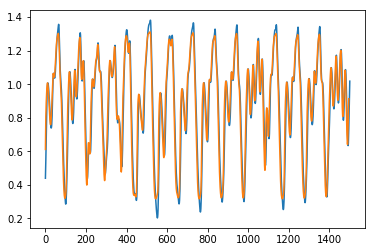

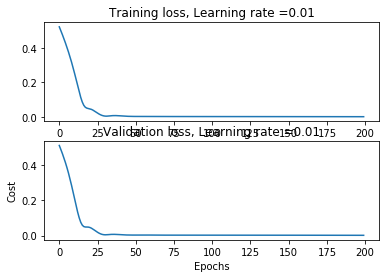

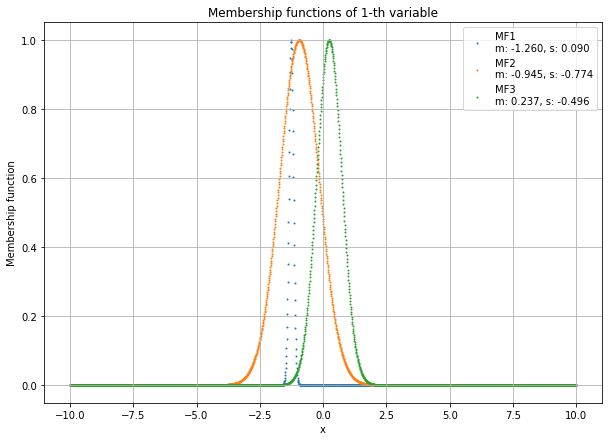

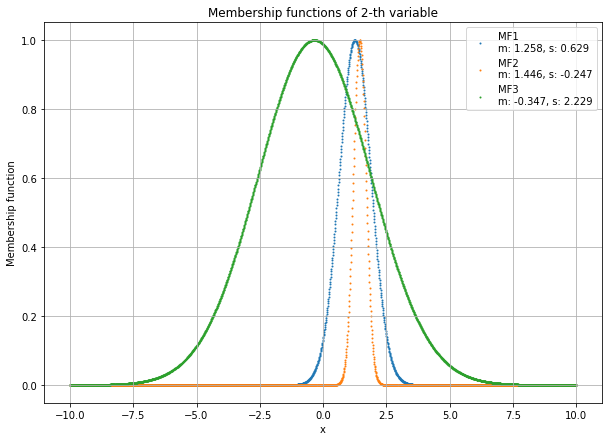

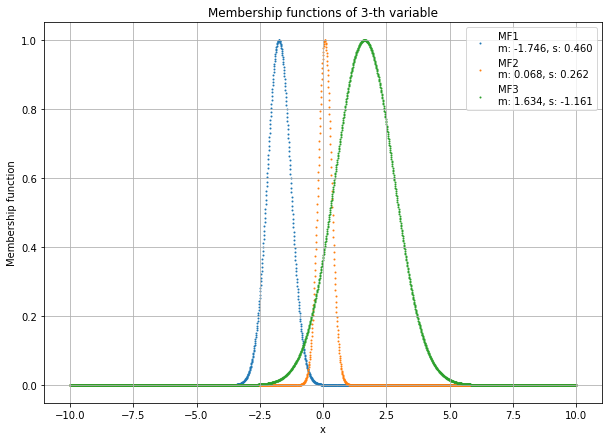

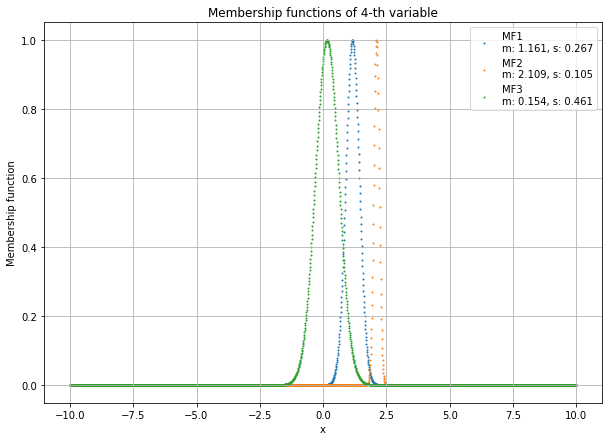

[ 0.868162    0.07970856  2.4194891   1.2143044  -0.18638778 -0.22479749
 -0.4588249   1.1157734   0.57559305  0.0342218  -1.1797385   1.5670964
 -0.10794424 -0.7242011  -0.5124068   1.6082425   0.06959379  1.6105399
  0.37097695 -1.4187851  -1.4030181  -0.31715015  1.7147374  -1.8169113
 -0.08790963  0.31014928 -0.4962525  -0.0184976  -0.6114341  -0.25718522
  3.3830006  -0.57588065  2.583632   -0.04530735  1.0129075  -0.6918664
  0.31084362  1.0083939  -0.70887697 -0.9768228  -0.67782813 -0.38008058
 -0.06229924  0.05552949 -0.00631319  1.5492988  -0.6190241  -0.5972852
  2.497816    0.47584793  2.0185437   0.47552928 -0.91824377  0.09233359
 -0.29302165  1.675313    0.10252532  4.211872    0.96135706 -0.05675133
  1.0531807   0.7687404   0.91234654  1.2188212   0.25769517  0.84304464
 -1.9801378  -0.14839575 -0.8429474   2.3241148   0.03635541 -0.25369182
 -0.21419469 -0.1406757  -0.25730932  4.4061933   0.13443989 -0.34798962
  1.202825    2.6247141   0.42632166]


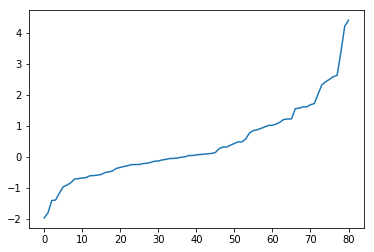

In [8]:
# Training
num_epochs = 200

# Initialize session to make computations on the Tensorflow graph
with tf.Session() as sess:
    # Initialize model parameters
    sess.run(fis.init_variables)
    trn_costs = []
    val_costs = []
    time_start = time.time()
    for epoch in range(num_epochs):
        #  Run an update step
        trn_loss, trn_pred = fis.fit(sess, trnData, trnLbls)
        # Evaluate on validation set
        val_pred, val_loss = fis.infer(sess, chkData, chkLbls)
        if epoch % 10 == 0:
            print("Train cost after epoch %i: %f" % (epoch, trn_loss))
        if epoch == num_epochs - 1:
            time_end = time.time()
            print("Elapsed time: %f" % (time_end - time_start))
            print("Validation loss: %f" % val_loss)
            # Plot real vs. predicted
            pred = np.vstack((np.expand_dims(trn_pred, 1), np.expand_dims(val_pred, 1)))
            plt.figure(1)
            plt.plot(mg_series)
            plt.plot(pred)
        trn_costs.append(trn_loss)
        val_costs.append(val_loss)
    # Plot the cost over epochs
    plt.figure(2)
    plt.subplot(2, 1, 1)
    plt.plot(np.squeeze(trn_costs))
    plt.title("Training loss, Learning rate =" + str(fis.learning_rate))
    plt.subplot(2, 1, 2)
    plt.plot(np.squeeze(val_costs))
    plt.title("Validation loss, Learning rate =" + str(fis.learning_rate))
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # Plot resulting membership functions
    fis.plotmfs(sess)
    plt.show()
    
    # Consequent values
    y = sess.run(fis.params)[2]
    print(y)
    plt.figure()
    plt.plot(sorted(y))

In [9]:
ts = np.loadtxt("/home/hung/githubtest/anfis/anfistest/trainingSet.txt", usecols=[1,2,3])
X = ts[:,0:2]
Y = ts[:,2]

In [10]:
from sklearn.cross_validation import train_test_split
trnData, chkData, trnLbls, chkLbls = train_test_split(X, Y, test_size=0.1, random_state=42)

/home/hung/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
fis2 = ANFIS(n_inputs=2, n_mfs=4, lossf='rmse', learning_rate=0.01)

Train cost after epoch 0: 1.248990
Train cost after epoch 10: 1.037596
Train cost after epoch 20: 0.651240
Train cost after epoch 30: 0.458562
Train cost after epoch 40: 0.394658
Train cost after epoch 50: 0.271863
Train cost after epoch 60: 0.193417
Train cost after epoch 70: 0.159782
Train cost after epoch 80: 0.149323
Train cost after epoch 90: 0.137776
Train cost after epoch 100: 0.127895
Train cost after epoch 110: 0.119146
Train cost after epoch 120: 0.111466
Train cost after epoch 130: 0.104271
Train cost after epoch 140: 0.097273
Train cost after epoch 150: 0.091492
Train cost after epoch 160: 0.086998
Train cost after epoch 170: 0.082889
Train cost after epoch 180: 0.079089
Train cost after epoch 190: 0.074974
Elapsed time: 0.417796
Validation loss: 0.089875


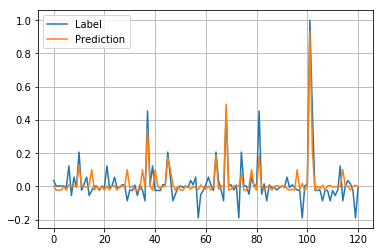

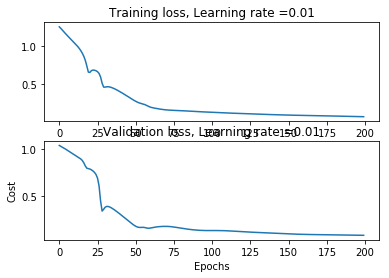

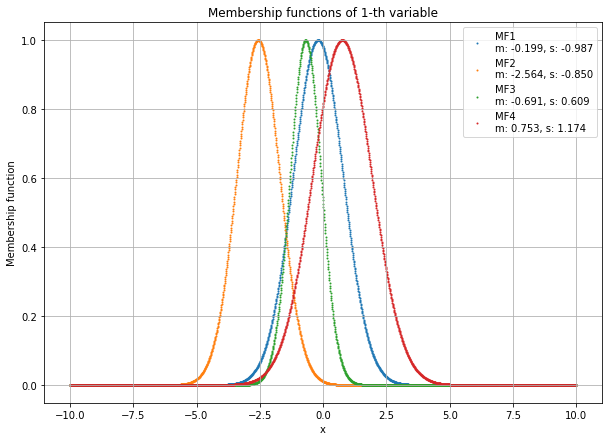

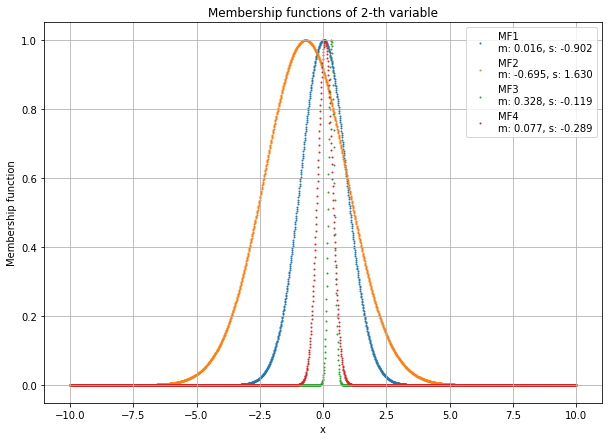

[ 2.5138576e+00  9.3526965e-01  4.7237816e-01  1.2897279e+00
 -3.5280239e-02  6.6179183e-04  1.2766888e+00 -6.4128421e-02
  3.6439910e+00 -1.7091920e+00  5.9172589e-01  1.3446822e+00
  7.8568846e-02 -2.2024881e-02  1.1514077e+00 -5.7735045e-02]


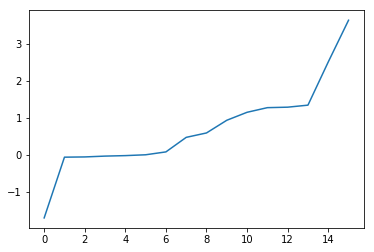

In [13]:
# Training
num_epochs = 200

# Initialize session to make computations on the Tensorflow graph
with tf.Session() as sess:
    # Initialize model parameters
    sess.run(fis2.init_variables)
    trn_costs = []
    val_costs = []
    time_start = time.time()
    for epoch in range(num_epochs):
        #  Run an update step
        trn_loss, trn_pred = fis2.fit(sess, trnData, trnLbls)
        # Evaluate on validation set
        val_pred, val_loss = fis2.infer(sess, chkData, chkLbls)
        if epoch % 10 == 0:
            print("Train cost after epoch %i: %f" % (epoch, trn_loss))
        if epoch == num_epochs - 1:
            time_end = time.time()
            print("Elapsed time: %f" % (time_end - time_start))
            print("Validation loss: %f" % val_loss)
            # Plot real vs. predicted
            pred = np.vstack((np.expand_dims(trn_pred, 1), np.expand_dims(val_pred, 1)))
            gtruth = np.vstack((np.expand_dims(trnLbls, 1), np.expand_dims(chkLbls, 1)))
            plt.figure(1)
            plt.plot(gtruth, label='Label')
            plt.plot(pred, label='Prediction')
            plt.grid(True)
            plt.legend()
        trn_costs.append(trn_loss)
        val_costs.append(val_loss)
    # Plot the cost over epochs
    plt.figure(2)
    plt.subplot(2, 1, 1)
    plt.plot(np.squeeze(trn_costs))
    plt.title("Training loss, Learning rate =" + str(fis2.learning_rate))
    plt.subplot(2, 1, 2)
    plt.plot(np.squeeze(val_costs))
    plt.title("Validation loss, Learning rate =" + str(fis2.learning_rate))
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    # Plot resulting membership functions
    fis2.plotmfs(sess)
    plt.show()
    
    # Consequent values
    y = sess.run(fis2.params)[2]
    print(y)
    plt.figure()
    plt.plot(sorted(y))